In [13]:
import os
import simulation
import pynbody
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
import numpy as np
import ipywidgets
import tqdm
from simulation.sfh_in_box import sfh, plot_sfh, plot_binned_sfh, bin_sfh
from astropy import constants as c
from astropy.table import Table
from simulation.luminosity import surface_brightness, color_plot
from simulation.angmom import sideon
from simulation.derived import feh, mgfe, gas_metals
from simulation.parsers.parse_info import parse_info
from simulation.derotating_box import get_omega_box, write_omega_box, Omega
from simulation.util import get_sim_name

In [2]:
from simulation.parsers.parse_trace import parse_dens_trace

In [3]:
sim_dir = "/media/michele/My Book/Michele/MySimulations/MovingBox/np/mb.41002_p300_a800_r600_t9.56/out"

In [4]:
sim = simulation.Simulation(sim_dir)

loading simulation: /media/michele/My Book/Michele/MySimulations/MovingBox/np/mb.41002_p300_a800_r600_t9.56/out
Found parameter file
Found compiler file
Found 445 snapshots
Loading cosmological parameters
Found trace file
Found dens_temp_trace file
dens_temp_trace.txt file is non-monotonic. Trying to recover


In [5]:
sim.times.min(), sim.times.max()

(SimArray(9.35767451, 'Gyr'), SimArray(13.68939532, 'Gyr'))

In [6]:
info = parse_info(os.path.join(sim_dir, 'info.txt'))

In [7]:
len(info), len(sim.trace)

(1081123, 1081123)

In [8]:
info.tail()

,step,t,z,dt
1081118,1080322,14.0,0.0,0.000004
1081119,1080323,14.0,0.0,0.000004
1081120,1080324,14.0,0.0,0.000004
1081121,1080325,14.0,0.0,0.000004
1081122,1080326,14.0,0.0,0.000004


In [9]:
info.step.is_monotonic_increasing

False

In [10]:
# sim = self
# dt = parse_info(os.path.join(sim._sim_dir,"info.txt")).dt.values

# # dt = make_info_monotonic_again(info).dt.values
# assert len(dt) == len(sim.trace), (len(dt), len(sim.trace))

# v_all = np.vstack([sim.trace.vx, sim.trace.vy, sim.trace.vz]).T

# # Finite difference
# num = v_all[1:]-v_all[0:-1]
# # den = (t[1:]-t[0:-1])[:, np.newaxis]
# # the first difference correspond to idx=2 (third) dt
# den = dt[1:, np.newaxis]
# a_all = num/den

# locations_a = np.digitize(sim.times_header, sim.trace.t[1:], right=True)
# v = v_all[locations_a]
# a = a_all[locations_a]
# om = Omega(v, a)

In [11]:
info = parse_info(os.path.join(sim_dir, 'info.txt'))
diff = info.step.diff()
restart_points = info.step[diff < 0]
idx_restart = [idx - ((info.step.loc[idx - 1]) - v + 1) for idx, v in zip(restart_points.index, restart_points.values)]
new_trace = sim.trace.copy()
for a, b in zip(idx_restart, restart_points.index):
    new_trace = new_trace.drop(sim.trace.index[slice(a,b)])

new_info = info.copy()
for a, b in zip(idx_restart, restart_points.index):
    new_info = new_info.drop(info.index[slice(a,b)])
    
dt = new_info.dt.values
assert len(dt) == len(new_trace), (len(dt), len(new_trace), len(sim.trace))


v_all = np.vstack([new_trace.vx, new_trace.vy, new_trace.vz]).T

# Finite difference
num = v_all[1:]-v_all[0:-1]
# den = (t[1:]-t[0:-1])[:, np.newaxis]
# the first difference correspond to idx=2 (third) dt
den = dt[1:, np.newaxis]
a_all = num/den

locations_a = np.digitize(sim.times_header, new_trace.t[1:], right=True)
v = v_all[locations_a]
a = a_all[locations_a]
om = Omega(v, a)

In [14]:
om

array([[-2.36963632e-03, -1.66359271e-03,  9.87348467e-01],
       [-2.05624293e-03, -1.44893731e-03,  8.33612000e-01],
       [ 4.16014761e-04,  3.81775785e-04,  1.19673996e+00],
       ...,
       [ 0.00000000e+00, -4.88243105e-03,  1.68192429e+00],
       [ 6.16702208e-03, -4.31691546e-03,  1.83586599e+00],
       [ 6.16702208e-03, -4.31691546e-03,  1.83586599e+00]])

In [15]:
sim_name = get_sim_name(sim_dir)
out_name = sim_name + "_omega.fits"
print('Writing {}...'.format(out_name))
write_omega_box(om, out_name)

Writing mb.41002_p300_a800_r600_t9.56_omega.fits...


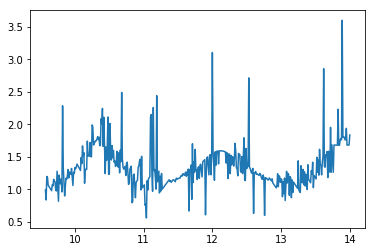

In [21]:
plt.plot(sim.times_header, om[:,2])

In [ ]:
v_all

In [10]:
om = get_omega_box(self)

ValueError: operands could not be broadcast together with shapes (1081122,3) (1081121,1) 

In [9]:
diff = info.step.diff(period)

In [12]:
restart_points = info.step[diff < 0]

In [13]:
restart_points

241509      241426
423358      423098
605706      605251
791409      790736
953189      952473
1044247    1043451
Name: step, dtype: int64

In [24]:
info.step[423358-5:423358+5]

423353    423270
423354    423271
423355    423272
423356    423273
423357    423274
423358    423098
423359    423099
423360    423100
423361    423101
423362    423102
Name: step, dtype: int64

In [31]:
delta_idx = (info.step.loc[restart_points.index[1] - 1]) - restart_points.iloc[1] + 1
delta_idx

177

In [33]:
idx_restart_was_written = restart_points.index[1] - delta_idx
idx_restart_was_written

423181

In [38]:
info.step.loc[idx_restart_was_written-5:idx_restart_was_written+5]

423176    423093
423177    423094
423178    423095
423179    423096
423180    423097
423181    423098
423182    423099
423183    423100
423184    423101
423185    423102
423186    423103
Name: step, dtype: int64

In [32]:
info.step.loc[restart_points.index[1] - delta_idx]

423098

In [37]:
idx_restart_1 = [restart_points.index[i] - ((info.step.loc[restart_points.index[i] - 1]) - restart_points.iloc[i] + 1) for i in range(len(restart_points))]
idx_restart_1

[241426, 423181, 605511, 791191, 953146, 1044167]

In [40]:
idx_restart = [idx - ((info.step.loc[idx - 1]) - v + 1) for idx, v in zip(restart_points.index, restart_points.values)]
idx_restart

[241426, 423181, 605511, 791191, 953146, 1044167]

In [41]:
na = info.copy()
for a, b in zip(idx_restart, restart_points.index):
    na = na.drop(info.step.index[slice(a,b)])

In [45]:
na.step.is_monotonic_increasing

True

In [59]:
na.iloc[241426-10:241426+10]

,step,t,z,dt
241416,241416,10.5316,0.299653,0.000004
241417,241417,10.5316,0.299653,0.000004
241418,241418,10.5316,0.299652,0.000004
241419,241419,10.5316,0.299652,0.000004
241420,241420,10.5316,0.299651,0.000004
241421,241421,10.5317,0.299651,0.000004
241422,241422,10.5317,0.299650,0.000004
241423,241423,10.5317,0.299650,0.000004
241424,241424,10.5317,0.299650,0.000004
241425,241425,10.5317,0.299649,0.000004


In [52]:
na.tail()

,step,t,z,dt
1081124,1080328,14.0,0.0,0.000004
1081125,1080329,14.0,0.0,0.000004
1081126,1080330,14.0,0.0,0.000004
1081127,1080331,14.0,0.0,0.000004
1081128,1080332,14.0,0.0,0.000004


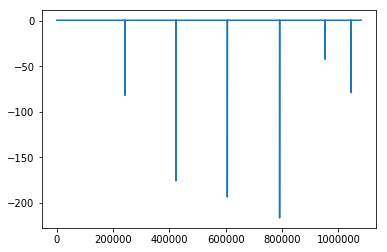

In [47]:
info.step.diff().plot()

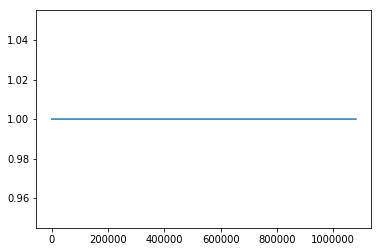

In [48]:
na.step.diff().plot()

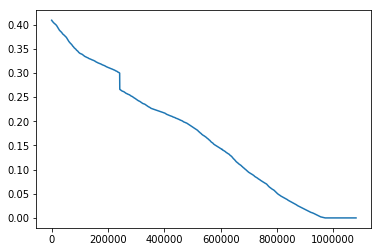

In [61]:
info.z.plot()

### Oh oh, Houston we've had a problem.

I have the redshift which is discontinuous. Just in the VSC run, only in the first restart. Maybe because there the quota was exceded and restart files were written badly

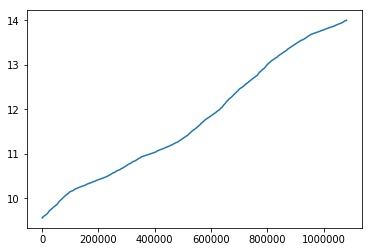

In [62]:
info.t.plot()

In [ ]:
np.digitize(self.times_header, info.trace.t[diff > 0])

In [18]:
info = parse_info(os.path.join('/media/michele/My Book/Michele/MySimulations/MovingBox/np/ongoing/vsc/mb.41002_p100_a800_r600_t9.56/out', 'info.txt'))

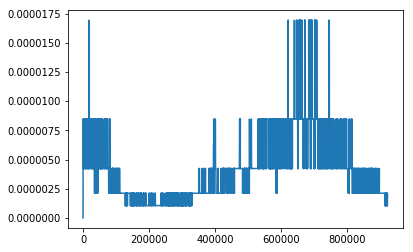

In [74]:
parse_info(os.path.join('/media/michele/My Book/Michele/MySimulations/MovingBox/np/ongoing/vsc/mb.41002_p100_a800_r600_t9.56/out', 'info.txt')).dt.plot()

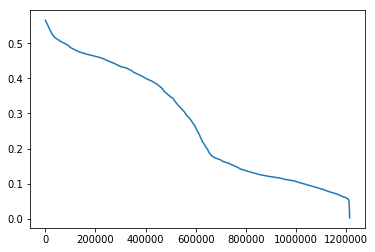

In [75]:
parse_info(os.path.join('/home/michele/sim/MySimulations/ng/mb.69002_p200_a800_r600/out', 'info.txt')).z.plot()

All together

In [ ]:
def make_info_monotonic_again(info):
    diff = info.step.diff(period)
    restart_points = info.step[diff < 0]
    idx_restart = [idx - ((info.step.loc[idx - 1]) - v + 1) for idx, v in zip(restart_points.index, restart_points.values)]

    na = info.copy()
    for a, b in zip(idx_restart, restart_points.index):
        na = na.drop(info.index[slice(a,b)])
    return na


In [11]:
diff = self.trace.t.diff()

In [12]:
self.trace.t[(diff < 0)]

241507     10.5317
423355     11.1021
605703     11.8780
791405     12.9376
953184     13.6765
1044241    13.8916
Name: t, dtype: float64